# Fig. 6: Injection heights with additional moisture flux

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import xarray as xr 
import seaborn as sns

plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams.update({'font.size': 20})

import warnings
warnings.filterwarnings("ignore")

## Funtions 

In [2]:
def quantile_height(ds, var="Qpassive_1", quantile=0.05):
    """
    Calculates the height above which a specified quantile percentage of the given variable are located.
    Primarily used with 'Qpassive_1' to determine the injection height.

    Parameters:
    ds (xarray.Dataset): The dataset containing the variable of interest.
    var (str): The variable name to use for calculation (default is "Qpassive_1").
    quantile (float): The quantile value (e.g., 0.05 for 5%) to determine the height threshold (default is 0.05).

    Returns:
    xarray.DataArray: The minimum height where the specified quantile condition is met.
    """
    
    ds = ds.mean(("lat", "lon"))
    rho = dens(ds)
    dz = -1 * z.differentiate("height")
    qplume = ds[var] * rho.values * dz.values
    qplume_sum = qplume.cumsum(dim="height")
    qplume_100 = qplume_sum.max(dim="height")
    qplume_q = qplume_100 * quantile
    height_q = ds['height'].where(qplume_q < qplume_sum)
    height_q_min = height_q.max(dim="height")

    return height_q_min


def dens(d): 
    R = 287.1
    densitiy = d.pres / (R * d.temp)
    return densitiy

In [3]:
def override_height(ds, z):
    return ds.assign_coords(height=z.values)

## Get Data

In [4]:
data_path = "../data/"
dsref = xr.open_mfdataset("/work/bb1174/user/jason/2024icon/icon/experiments/merged_dsets/merged_les_000.nc", engine = 'netcdf4').isel(time = 4).squeeze()

z = xr.open_mfdataset("/work/bb1174/user/jason/2024icon/icon/experiments/les_000_v2/lon_lat_3d_full_base_DOM01_ML_20191230T120000Z.nc", engine = 'netcdf4').mean("time").squeeze().mean(("lat", "lon"))["z_mc"]/1000
z = z.assign_coords(height=dsref.height)

In [5]:
ds21 = override_height(xr.open_mfdataset(data_path + "exp_021.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
ds22 = override_height(xr.open_mfdataset(data_path + "exp_022.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
ds23 = override_height(xr.open_mfdataset(data_path + "exp_023.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
ds24 = override_height(xr.open_mfdataset(data_path + "exp_024.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)

dsets = [ds21, ds22, ds23, ds24]

## Prepare Plot

In [6]:
lhfl = [0, 10, 20, 30]
steps = ["0", "10%", "20%", "30%"]
q1, q3 = 0.05, 0.5  # Quantiles for analysis

# Lists to hold quantile values for plotting
quants1, quants3 = [], []
# Calculate quantile heights for each dataset
for j, ds in enumerate(dsets):
    quants1.append(quantile_height(ds.mean("time"), quantile=q1).values)
    quants3.append(quantile_height(ds.mean("time"), quantile=q3).values)


## Plot Figure

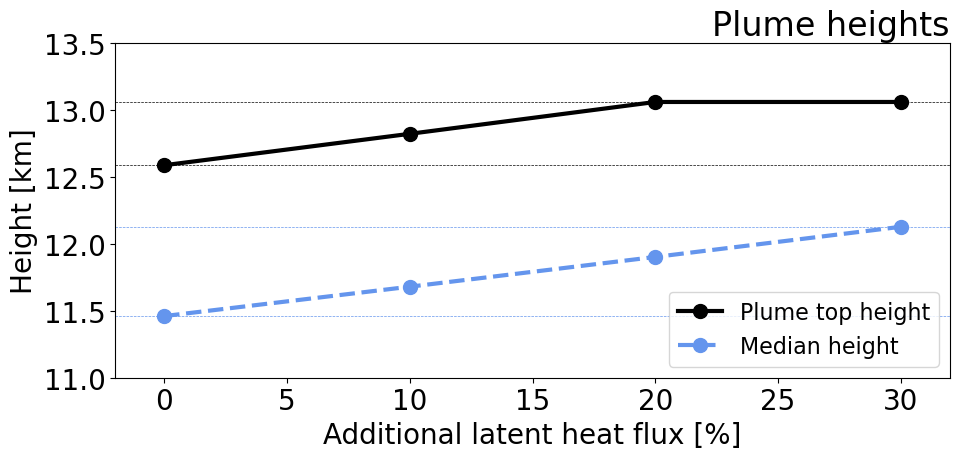

In [7]:
# Define parameters

# Set up y-ticks and figure
y_ticks = np.arange(11,14,0.5)
fig, ax = plt.subplots(1, figsize=[10, 5])

# Plot injection and median heights
ax.plot(lhfl, quants1, color="black", linewidth=3, marker="o", markersize=10, label="Plume top height")
ax.plot(lhfl, quants3, color="cornflowerblue", linewidth=3, marker="o", markersize=10, label="Median height", linestyle="--")

# Add horizontal lines for start and end quantile heights
for q_vals, color in zip([quants1, quants3], ["black", "cornflowerblue"]):
    ax.hlines(y=q_vals[0], xmin=-2, xmax=32, color=color, linestyle="--", linewidth=0.5)
    ax.hlines(y=q_vals[-1], xmin=-2, xmax=32, color=color, linestyle="--", linewidth=0.5)

# Set axis properties
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks)
ax.set_xlabel("Additional latent heat flux [%]")
ax.set_ylabel("Height [km]")
ax.set_title("Plume heights",  loc="right")
ax.set_ylim(11,13.5)
ax.set_xlim(-2,32)
#sns.despine(ax=ax)

# Add legends and customize plot appearance
ax.legend(loc='lower right', fontsize=16)

# Display and save the plot
plt.tight_layout()
plt.show()

my_path = "./figs/"
fig.savefig(my_path + 'fig06.png', dpi=300, bbox_inches='tight')
fig.savefig(my_path + 'fig06_lq.png', dpi=50, bbox_inches='tight')